<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#Матрица-ошибок" data-toc-modified-id="Матрица-ошибок-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Матрица ошибок</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. 
<br>Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Загрузим библиотеки и инструменты для проекта

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

Загрузим данные и рассмотрим их

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


в комментариях присутствуют спец.символы, разный регистр написания

In [5]:
data.shape

(159571, 2)

In [6]:
# посмотрим на кол-во комментариев
data['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

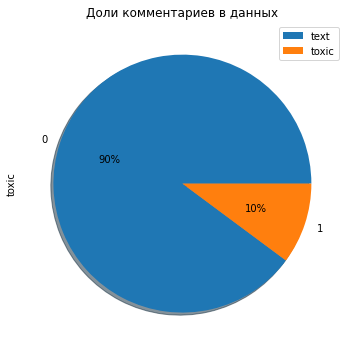

In [7]:
# построим график с долевым распределением комментариев
data['toxic'].value_counts().plot(kind='pie', autopct='%1.0f%%', shadow=True, figsize=(5,5))
plt.legend(['text','toxic'])
plt.title('Доли комментариев в данных')
plt.tight_layout()


Данные содержат:
- 2 столбца и 159571 записей
- 10% - токсичные комментарии

Очистим данные с помощью функций от спец.символов и цифр, удалим стоп-слова и лемматизируем данные для дальнейшей работы

In [8]:
# функция удаления спец.символов и цифр из данных
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(text.lower().split())

In [9]:
# функция удаления стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

def remove_stopwords(text):
    clean_text = [w for w in text.lower().split() if not w in stopwords]  
    return clean_text

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# лемматизируем текст
lemmatizer = nltk.WordNetLemmatizer()

def lemmatize(text):
    clean_text = [lemmatizer.lemmatize(word) for word in text]
    return clean_text

In [11]:
# добавим новые столбцы в таблицу
data['clear_text'] = data['text'].apply(lambda x: clear_text(x))
data['without_stopwords'] = data['clear_text'].apply(lambda x: remove_stopwords(x))
data['lemma'] = data['without_stopwords'].apply(lambda x: lemmatize(x))
data.head(3)

,text,toxic,clear_text,without_stopwords,lemma
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,"[explanation, edits, made, username, hardcore,...","[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,"[aww, matches, background, colour, seemingly, ...","[aww, match, background, colour, seemingly, st..."
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,"[hey, man, really, trying, edit, war, guy, con...","[hey, man, really, trying, edit, war, guy, con..."


Подготовим данные для обучения моделей

In [12]:
# выделим признаки и посмотрим их размер
target = data['toxic']
features = data.drop('toxic', axis = 1)

print('Целевой признак:', target.shape)
print('Признаки:', features.shape)


Целевой признак: (159571,)
Признаки: (159571, 4)


In [13]:
# разделим данные на обучающую (75%) и тестовую выборки (25%)
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target,
                                                                            test_size=0.25, 
                                                                            random_state=12345)

In [14]:
# посмотрим на размер полученных выборок
samples = {'Размер обучающей выборки' : features_train, 
          'Размер тестовой выборки': features_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (119678, 4)
Размер тестовой выборки: (39893, 4)


In [15]:
# преобразуем данные к типу U
corpus_train = features_train['without_stopwords'].astype('U')
corpus_test = features_test['without_stopwords'].astype('U')
corpus_test[:3]

146790    ['ahh', 'shut', 'fuck', 'douchebag', 'sand', '...
2941      ['reply', 'thing', 'texas', 'commerce', 'bank'...
115087    ['reply', 'hey', 'could', 'least', 'mention', ...
Name: without_stopwords, dtype: object

Вычислим **TF-IDF** для корпуса текстов

In [16]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf = count_tf_idf.fit(corpus_train)

In [17]:
features_train = tf_idf.transform(corpus_train)
features_test = tf_idf.transform(corpus_test)

**Вывод:**
- данные загружены и рассмотрены
- комментарии очищены от спец.символов, стоп-слов и лемматизированы для дальнейшего обучения моделей
- подготовлены признаки и выделены выборки в данных в отношении 75% (обучающая) и 25% (тестовая)

Данные подготовлены для обучения моделей.

## Обучение

### LogisticRegression

In [18]:
%%time
model = LogisticRegression(random_state=12345, solver = 'liblinear', class_weight='balanced') 
model.fit(features_train, target_train)
predictions_lr = model.predict(features_test)

f1_lr = f1_score(target_test, predictions_lr)
print('F1 LogisticRegression:', f1_lr.round(2))

F1 LogisticRegression: 0.76
CPU times: user 7.2 s, sys: 6.17 s, total: 13.4 s
Wall time: 13.4 s


### DecisionTreeClassifier

Подберем параметры модели

In [19]:
%%time
for depth in range(10, 51, 10):
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight = 'balanced')
    f1 = cross_val_score(model_dtc, features_train, target_train, cv=2, scoring='f1')
    print("F1 при depth =", depth, ":", f1)


F1 при depth = 10 : [0.54428086 0.54232684]
F1 при depth = 20 : [0.59885057 0.59330498]
F1 при depth = 30 : [0.61575606 0.60587622]
F1 при depth = 40 : [0.62239057 0.6072673 ]
F1 при depth = 50 : [0.61378038 0.59864678]
CPU times: user 2min 39s, sys: 0 ns, total: 2min 39s
Wall time: 2min 40s


Применим наилучший параметр глубины для предсказания модели

In [20]:
%%time
model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=40, class_weight = 'balanced')
model_dtc.fit(features_train, target_train)
predictions_dtc = model_dtc.predict(features_test)
f1_dtc = f1_score(target_test, predictions_dtc)
print("F1 DecisionTreeClassifier: ", f1_dtc.round(2))

F1 DecisionTreeClassifier:  0.59
CPU times: user 39.5 s, sys: 0 ns, total: 39.5 s
Wall time: 39.7 s


### RandomForestClassifier

Подберем параметры модели

In [21]:
%%time
for depth in range(10, 51, 10):
    for estimator in range(30, 61, 30):
        model_rfc = RandomForestClassifier(random_state=12345, max_depth=depth, class_weight = 'balanced', n_estimators=estimator)
        f1 = cross_val_score(model_rfc, features_train, target_train, cv=2, scoring='f1')
        print("F1 при depth =", depth, ":", "при estimator =", estimator, ":", f1)


F1 при depth = 10 : при estimator = 30 : [0.31565239 0.32866344]
F1 при depth = 10 : при estimator = 60 : [0.33954035 0.34749906]
F1 при depth = 20 : при estimator = 30 : [0.35236635 0.39240094]
F1 при depth = 20 : при estimator = 60 : [0.37979613 0.40306914]
F1 при depth = 30 : при estimator = 30 : [0.38524823 0.41502762]
F1 при depth = 30 : при estimator = 60 : [0.41690068 0.42334218]
F1 при depth = 40 : при estimator = 30 : [0.419716   0.44479738]
F1 при depth = 40 : при estimator = 60 : [0.43794733 0.45306754]
F1 при depth = 50 : при estimator = 30 : [0.44374724 0.45348837]
F1 при depth = 50 : при estimator = 60 : [0.45777912 0.47079355]
CPU times: user 5min 37s, sys: 285 ms, total: 5min 38s
Wall time: 5min 40s


Применим наилучший параметр глубины для предсказания модели

In [22]:
%%time
model_rfc = RandomForestClassifier(random_state=12345, max_depth=50, n_estimators=60, class_weight = 'balanced')
model_rfc.fit(features_train, target_train)
predictions_rfc = model_rfc.predict(features_test)
f1_rfc = f1_score(target_test, predictions_rfc)
print("F1 RandomForestClassifier: ", f1_rfc.round(2))


F1 RandomForestClassifier:  0.47
CPU times: user 30.5 s, sys: 23.1 ms, total: 30.6 s
Wall time: 30.7 s


### Матрица ошибок

Построим матрицу ошибок по наилучшей модели (LogisticRegression), которая удовлетворяет условию задания (f1>0,75)

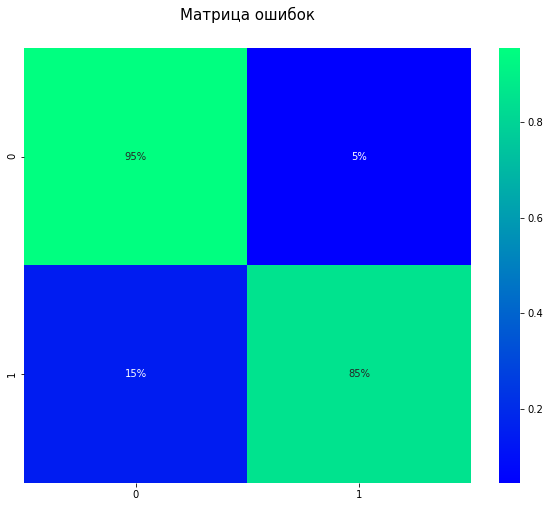

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(target_test, predictions_lr, normalize='true'),annot=True,fmt='.0%',cmap="winter")
plt.title('Матрица ошибок', y=1.05, size=15);


## Выводы

В ходе работы:
- проанализировали данные (10% данных составляют токсичные комментарии)
- подготовлили текст для обучения моделей (привели к нижнему регистру, очистили от символов и стоп-слов, лемматизировали)
- выделили признаки и разделили данные на 2 выборки: обучающую (75%) и тестовую (25%)
- обучили 3 модели: LogisticRegression, DecisionTreeClassifier и RandomForestClassifier
- наилучшую метрику F1 показывает модель LogisticRegression = 0,76, что удовлетворяет условию задачи
- матрица ошибок, построенная на моделе LogisticRegression, также соответствует условию по ошибкам

Цель проекта достигнута, для дальнейшего использования рекомендуется модель LogisticRegression с F1 = 0,76 и максимальной скоростью работы.